In [4]:
import os
import pandas as pd

df = pd.read_csv(r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\Turning_human_labels.csv")
df.columns

Index(['Turn ID', 'Participant ID number', 'PD_or_C',
       'number_of_turning_steps', 'turning_angle', 'type_of_turn',
       'turning_duration', 'On_or_Off_medication', 'DBS_state',
       'clinical_assessment'],
      dtype='object')

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

def angle_between_vectors(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    cos_theta = np.dot(v1, v2) / (norm1 * norm2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)

# 计算转弯角度（keypoints_seq: [帧数, 17, 3]）
def estimate_turning_angle(keypoints_seq, start_idx, end_idx):
    kps_start = keypoints_seq[start_idx]
    kps_end = keypoints_seq[end_idx]
    vec_hip_start = kps_start[5] - kps_start[2]  # 左髋(5) - 右髋(2)
    vec_hip_end = kps_end[5] - kps_end[2]
    vec_knee_start = kps_start[6] - kps_start[3]  # 左膝(6) - 右膝(3)
    vec_knee_end = kps_end[6] - kps_end[3]
    hip_angle = angle_between_vectors(vec_hip_start, vec_hip_end)
    knee_angle = angle_between_vectors(vec_knee_start, vec_knee_end)
    avg_angle = (hip_angle + knee_angle) / 2
    quantized_angle = round(avg_angle / 45) * 45
    return quantized_angle

def extract_turn_id(folder_name):
    parts = folder_name.split('_')
    if len(parts) >= 4:
        try:
            return int(parts[-1])  # 如Pt204_C_n_350 -> 350
        except ValueError:
            return None
    return None

base_dir = Path(r"E:\学习工作\PD\pks\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV")  # 您的3D关键点主文件夹
labels_path = Path(r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\Turning_human_labels.csv")  # 标签CSV路径

labels_df = pd.read_csv(labels_path)
labels_df['turning_angle_num'] = labels_df['turning_angle'].str.replace('_degrees', '').astype(float)  # 转换为数字，如90.0

results = []
for folder in base_dir.iterdir():
    if not folder.is_dir():
        continue
    input_3d_path = folder / "input_3D" / "keypoints3d.csv"
    if not input_3d_path.exists():
        continue
    
    df = pd.read_csv(input_3d_path)
    num_frames = df.shape[0]
    arr = df.to_numpy(dtype=np.float32).reshape(num_frames, 17, 3)
    
    calc_angle = estimate_turning_angle(arr, 0, num_frames - 1)
    
    turn_id = extract_turn_id(folder.name)
    if turn_id is not None:
        label_row = labels_df[labels_df['Turn ID'] == turn_id]
        if not label_row.empty:
            true_angle = label_row['turning_angle_num'].values[0]
            error = abs(calc_angle - true_angle)
        else:
            true_angle = None
            error = None
    else:
        true_angle = None
        error = None
    
    results.append({
        "folder": folder.name,
        "turn_id": turn_id,
        "calculated_angle": calc_angle,
        "true_angle": true_angle,
        "error": error
    })

results_df = pd.DataFrame(results)
results_df.to_csv(str(base_dir / "turning_angles_comparison.csv"), index=False)

# 统计（过滤有标签的）
valid_results = results_df.dropna(subset=['true_angle'])
if not valid_results.empty:
    mean_mae = valid_results['error'].mean()
    print(f"平均绝对误差 (MAE): {mean_mae:.2f}° (论文预期: ~34.7°)")
    print("前5个结果:")
    print(valid_results.head())
else:
    print("未找到匹配的Turn ID，无法计算误差。")


平均绝对误差 (MAE): 40.24° (论文预期: ~34.7°)
前5个结果:
          folder  turn_id  calculated_angle  true_angle  error
0  Pt204_C_n_350      350               180       135.0   45.0
1  Pt204_C_n_360      360               135        90.0   45.0
2  Pt204_C_n_365      365                90        90.0    0.0
3  Pt204_C_n_368      368                90        90.0    0.0
4  Pt204_C_n_377      377                90       135.0   45.0


In [ ]:
import pandas as pd

df = pd.read_csv(r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv")


df['calculated_angle'] = df['calculated_angle'].astype(str) + '_degrees'

print("修改後的數據：")
print(df)

df.to_csv(r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv", index=False)

print("\n已成功保存到 data_modified.csv 文件中！")

修改後的數據：
      Turn ID  Participant ID number PD_or_C  number_of_turning_steps  \
0           0                    230       C                        4   
1           2                    230       C                        2   
2           4                    230       C                        2   
3           5                    230       C                        2   
4           7                    230       C                        2   
...       ...                    ...     ...                      ...   
1744     3740                    253      PD                        4   
1745     3741                    253      PD                        3   
1746     3742                    253      PD                        3   
1747     3743                    416       C                        3   
1748     3744                    416       C                        3   

     calculated_angle turning_angle  error type_of_turn  turning_duration  \
0         135_degrees    90_degrees   

In [ ]:
import pandas as pd

# --- 您需要修改的參數 ---
file1_path = r"E:\学习工作\PD\pks\Turning\Data\cleaned_turning_project_2d_features.csv"
file2_path = r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv"
column_to_compare = 'Turn ID'  # 指定要比較的欄位名稱
# -------------------------

try:

    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # 2. 檢查指定的欄位是否存在於兩個文件中
    if column_to_compare not in df1.columns or column_to_compare not in df2.columns:
        print(f"錯誤：欄位 '{column_to_compare}' 並不都存在於兩個文件中。")
        exit()

    set1 = set(df1[column_to_compare].dropna().unique())
    set2 = set(df2[column_to_compare].dropna().unique())


    in_file1_only = list(set1 - set2)
    
    in_file2_only = list(set2 - set1)

    # 5. 打印結果
    print(f"--- 正在比較文件 '{file1_path}' 和 '{file2_path}' 的 '{column_to_compare}' 欄位 ---\n")

    if in_file1_only:
        print(f"✅ 在 '{file1_path}' 中獨有 (即 '{file2_path}' 中缺少) 的數據:")
        for item in in_file1_only:
            print(f"  - {item}")
    else:
        print(f"✅ '{file1_path}' 中的所有數據都在 '{file2_path}' 中存在。\n")

    print("-" * 20)

    if in_file2_only:
        print(f"✅ 在 '{file2_path}' 中獨有 (即 '{file1_path}' 中缺少) 的數據:")
        for item in in_file2_only:
            print(f"  - {item}")
    else:
        print(f"✅ '{file2_path}' 中的所有數據都在 '{file1_path}' 中存在。\n")

except FileNotFoundError as e:
    print(f"文件未找到錯誤：{e}")

--- 正在比較文件 'E:\学习工作\PD\pks\Turning\Data\cleaned_turning_project_2d_features.csv' 和 'E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv' 的 'Turn ID' 欄位 ---

✅ 'E:\学习工作\PD\pks\Turning\Data\cleaned_turning_project_2d_features.csv' 中的所有數據都在 'E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv' 中存在。

--------------------
✅ 在 'E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv' 中獨有 (即 'E:\学习工作\PD\pks\Turning\Data\cleaned_turning_project_2d_features.csv' 中缺少) 的數據:
  - 1408
  - 3712
  - 901
  - 2951
  - 8
  - 137
  - 904
  - 1934
  - 1807
  - 145
  - 790
  - 535
  - 3607
  - 3225
  - 3354
  - 3744
  - 3612
  - 3743
  - 3232
  - 417
  - 674
  - 675
  - 1186
  - 37
  - 2980
  - 39
  - 3237
  - 41
  - 3499
  - 47
  - 1967
  - 817
  - 3634
  - 53
  - 565
  - 440
  - 697
  - 2489
  - 955
  - 2239
  - 1601
  - 711
  - 328
  - 714
  - 204
  - 2636
  - 2893
  - 80
  - 3538
  - 728
  - 3289
  - 733
  - 1502
  - 3423
  - 3553
  - 2786
  - 1254
 

#删除 缺失的 然后跑开阳的 分类模型

In [ ]:

import pandas as pd


ids_to_delete = [
    1408, 3712, 901, 2951, 8, 137, 904, 1934, 1807, 145, 
    790, 535, 3607, 3225, 3354, 3744, 3612, 3743, 3232, 417, 
    674, 675, 1186, 37, 2980, 39, 3237, 41, 3499, 47, 
    1967, 817, 3634, 53, 565, 440, 697, 2489, 955, 2239, 
    1601, 711, 328, 714, 204, 2636, 2893, 80, 3538, 728, 
    3289, 733, 1502, 3423, 3553, 2786, 1254, 876, 2668, 3180, 
    2289, 2673, 3186, 1140, 2938, 2813, 2686, 3711
]

# --- 您可能需要修改的参数 ---
file_path = r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv"
column_name = 'Turn ID'       # 要检查的栏位名称
output_path = r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle_deleted.csv" # 保存结果的新文件名
# -----------------------------

try:
    # 2. 读取您的 CSV 文件
    print(f"正在读取文件: {file_path}...")
    df = pd.read_csv(file_path)
    print(f"文件读取成功，原始文件共有 {len(df)} 行。")

    # 检查栏位是否存在
    if column_name not in df.columns:
        print(f"错误：文件中找不到名为 '{column_name}' 的栏位。请检查栏位名称是否正确。")
    else:
        # 3. 筛选数据：保留 'Turn ID' 不在 ids_to_delete 列表中的所有行
        # df[column_name].isin(ids_to_delete) 会返回一个布林序列（True/False）
        # 前面的 ~ 符号代表 "取反"，也就是选择所有为 False 的行
        original_rows = len(df)
        df_filtered = df[~df[column_name].isin(ids_to_delete)]
        new_rows = len(df_filtered)

        # 4. 打印操作报告
        print(f"操作完成。共删除了 {original_rows - new_rows} 行。")
        print(f"新文件将包含 {new_rows} 行。")

        # 5. 将处理后的结果保存到新的 CSV 文件
        # index=False 表示在保存时不去掉行号，这是通常需要的设置
        df_filtered.to_csv(output_path, index=False)
        print(f"\n成功！已将结果保存到新文件: '{output_path}'")

except FileNotFoundError:
    print(f"错误: 文件 '{file_path}' 未找到。请确保脚本和 CSV 文件在同一个目录下，或者提供完整的文件路径。")
except Exception as e:
    print(f"发生了一个意外错误: {e}")



正在读取文件: E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle.csv...
文件读取成功，原始文件共有 1749 行。
操作完成。共删除了 68 行。
新文件将包含 1681 行。

成功！已将结果保存到新文件: 'E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_turning_angle_deleted.csv'


# 2D Plot

In [46]:
# Connected-skeleton animation for generated keypoints with GIF export and styling
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.collections import LineCollection
from pathlib import Path
import pandas as pd
import imageio
import io

df = pd.read_csv(r'Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt416_C_n_3668\input_2D\keypoints.csv')


Loaded frames: 58, array shape: (58, 34), keypoints shape: (58, 17, 2)
Saving 2D animation as GIF...


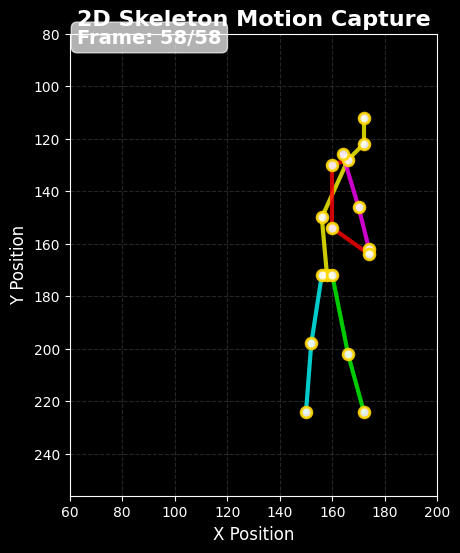

In [47]:

# Set style for better visuals
plt.style.use('dark_background')  # Dark theme

dimension = 2
number_of_joints = 17
expected_cols = number_of_joints * dimension


# Keep exactly the first 34 columns and coerce to numeric
df = df.iloc[:, :expected_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(axis=0, how="any")  # drop any rows with bad entries (e.g., 'e+02.1' glitches)

arr = df.to_numpy(dtype=np.float32)             # shape: (T, 34)
T = arr.shape[0]
keypoints = arr.reshape(T, number_of_joints, dimension)  # (T, 17, 2)

print(f"Loaded frames: {T}, array shape: {arr.shape}, keypoints shape: {keypoints.shape}")  # (T,17,2)

# render animations inline as JS
rc('animation', html='jshtml')

# Define connections with colors for different body parts
connections = [
    ([0, 1], 'cyan'),    # head-neck
    ([1, 2], 'cyan'),    # neck-torso
    ([2, 3], 'cyan'),    # torso connections
    ([0, 4], 'lime'),    # left arm
    ([4, 5], 'lime'),    
    ([5, 6], 'lime'),    
    ([0, 7], 'yellow'),  # right arm
    ([7, 8], 'yellow'), 
    ([8, 9], 'yellow'), 
    ([9, 10], 'yellow'),
    ([8, 11], 'magenta'), # left leg
    ([11, 12], 'magenta'), 
    ([12, 13], 'magenta'),
    ([8, 14], 'red'),    # right leg
    ([14, 15], 'red'), 
    ([15, 16], 'red'),
]

T = keypoints.shape[0]
assert keypoints.shape == (T, 17, 2)

# fixed axes so the view doesn't jump
xmin, xmax = keypoints[:,:,0].min(), keypoints[:,:,0].max()
ymin, ymax = keypoints[:,:,1].min(), keypoints[:,:,1].max()

# Create figure with better styling
fig, ax = plt.subplots(figsize=(6, 6), facecolor='black')
ax.set_facecolor('black')
ax.set_title("2D Skeleton Motion Capture", fontsize=16, color='white', fontweight='bold')
ax.set_xlim(xmin-20, xmax+20)
ax.set_ylim(ymin-20, ymax+20)
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()  # image coords

# Style the axes
ax.grid(True, alpha=0.3, color='gray', linestyle='--')
ax.set_xlabel('X Position', color='white', fontsize=12)
ax.set_ylabel('Y Position', color='white', fontsize=12)

# draw first frame with styling
pts0 = keypoints[0]
sc = ax.scatter(pts0[:,0], pts0[:,1], s=60, c='white', edgecolors='gold', 
                linewidth=2, alpha=0.9, zorder=5)

# create LineCollection for bones with different colors
line_objects = []
for (i, j), color in connections:
    line = ax.plot([pts0[i,0], pts0[j,0]], [pts0[i,1], pts0[j,1]], 
                   color=color, linewidth=3, alpha=0.8, zorder=3)[0]
    line_objects.append(line)

# Frame counter text
frame_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                     fontsize=14, color='white', fontweight='bold',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

def update(t):
    pts = keypoints[t]
    sc.set_offsets(pts)
    
    # update bone segments with colors
    for idx, ((i, j), color) in enumerate(connections):
        line_objects[idx].set_data([pts[i,0], pts[j,0]], [pts[i,1], pts[j,1]])
    
    # update frame counter
    frame_text.set_text(f"Frame: {t+1}/{T}")
    
    return [sc] + line_objects + [frame_text]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=T, interval=1000/30, blit=True, repeat=True)

# Save as GIF
print("Saving 2D animation as GIF...")
output_gif = 'Pt204_C_n_479.gif'

# Create a writer for the gif
writer = animation.PillowWriter(fps=30)
# ani.save(output_gif, writer=writer, dpi=100)

# print(f"2D Animation saved as {output_gif}")

# Display the animation
ani  # displays inline in Jupyter

In [ ]:
    output_dir = Path('Data/turning_2D3D_skeletons_coarsened/Turning_coarsen_CSV/Pt416_C_n_3668')

Output directory set to: Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt631_PD_n_1222
Loaded 3D keypoints with shape: (65, 17, 3)

Starting to save the animation...
Animation saved as '3d_skeleton_animation.gif' in the current directory.


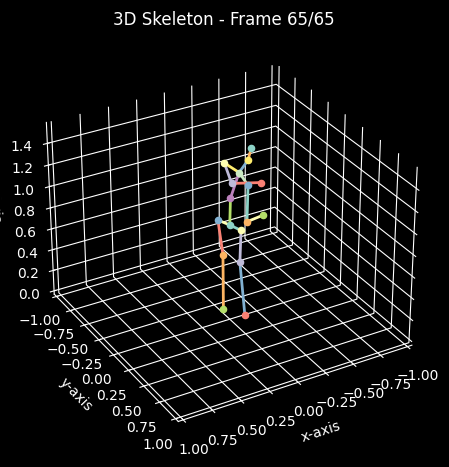

In [51]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec

# Note: You may need to install ffmpeg for video saving.
# On Ubuntu/Debian, use: sudo apt-get install ffmpeg
# On macOS, use: brew install ffmpeg
# On Windows, download from https://ffmpeg.org/download.html and add to PATH.
# For GIF saving, you need Pillow: pip install Pillow
from matplotlib.animation import PillowWriter

def main():
    """Main function to load data, create, and save the animation."""

    # ### Path to dataset ###
    # This assumes the script is run from a location where `Data` is a subfolder.

    print(f"Output directory set to: {output_dir}")

    # Load the 3D keypoints data
    keypoints3d_csv_path = output_dir / 'input_3D/keypoints3d.csv'

    if not keypoints3d_csv_path.exists():
        raise FileNotFoundError(f"File not found: {keypoints3d_csv_path}")

    dimension = 3
    number_of_joints = 17
    keypoints3d_csv = np.loadtxt(keypoints3d_csv_path, delimiter=',', skiprows=1)
    keypoints3d = keypoints3d_csv.reshape(keypoints3d_csv.shape[0], number_of_joints, dimension)
    print(f"Loaded 3D keypoints with shape: {keypoints3d.shape}")

    # 17 keypoint configuration (connection definitions)
    I = np.array([0, 0, 1, 4, 2, 5, 0, 7,  8,  8, 14, 15, 11, 12, 8,  9])
    J = np.array([1, 4, 2, 5, 3, 6, 7, 8, 14, 11, 15, 16, 12, 13, 9, 10])
    connections = list(zip(I, J))

    # Set up the figure and 3D axis
    fig = plt.figure(figsize=(9.6, 5.4))
    gs = gridspec.GridSpec(1, 1)
    gs.update(wspace=-0.00, hspace=0.05)
    ax = plt.subplot(gs[0], projection='3d')
    ax.view_init(elev=30, azim=60)

    # Set axis limits
    zmin, zmax = np.min(keypoints3d[:,:,2]), np.max(keypoints3d[:,:,2])
    RADIUS = 1
    ax.set_xlim3d([-RADIUS, RADIUS])
    ax.set_ylim3d([-RADIUS, RADIUS])
    ax.set_zlim3d([zmin, zmax])

    # Styling for the plot
    white = (1.0, 1.0, 1.0, 0.0)
    ax.xaxis.set_pane_color(white)
    ax.yaxis.set_pane_color(white)
    ax.zaxis.set_pane_color(white)

    ax.tick_params('x', labelbottom=True)
    ax.tick_params('y', labelleft=True)
    ax.tick_params('z', labelleft=True)

    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

    # Initialize empty line objects for each connection
    lines = []
    points = []
    for i in range(len(connections)):
        line, = ax.plot([], [], [], lw=2)
        lines.append(line)

    # Initialize scatter points for joints
    for i in range(number_of_joints):
        point = ax.scatter([], [], [], s=20)
        points.append(point)

    def update(frame):
        """Update function for the animation, called for each frame."""
        vals = keypoints3d[frame]
        
        # Update lines (bones)
        for i, (start_idx, end_idx) in enumerate(connections):
            x = [vals[start_idx, 0], vals[end_idx, 0]]
            y = [vals[start_idx, 1], vals[end_idx, 1]]
            z = [vals[start_idx, 2], vals[end_idx, 2]]
            lines[i].set_data_3d(x, y, z)
        
        # Update scatter points (joints)
        for i in range(number_of_joints):
            points[i]._offsets3d = ([vals[i, 0]], [vals[i, 1]], [vals[i, 2]])
        
        ax.set_title(f'3D Skeleton - Frame {frame+1}/{len(keypoints3d)}')
        return lines + points

    # Create animation with 30 FPS
    T = keypoints3d.shape[0]
    ani = animation.FuncAnimation(fig, update, frames=T, interval=1000/30, blit=False)
    
    # --- New code to save the animation ---
    print("\nStarting to save the animation...")
    
    # Define the output filename
    output_filename = '3d_skeleton_animation.gif'

    # Set up the writer for GIF
    writer = PillowWriter(fps=30)
    
    # Save the animation
    ani.save(output_filename, writer=writer)
    
    print(f"Animation saved as '{output_filename}' in the current directory.")
ani
# Run the main function when the script is executed
if __name__ == '__main__':
    main()

# Get Original data from original csv

In [8]:
df = pd.read_excel(r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_180_pivot_turn.xlsx")
df.to_csv(r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_180_pivot_turn.csv",index = False)

# Find their CSV_file

In [14]:
import os
from pathlib import Path
import shutil

# 配置：源目录与目标目录
SRC = Path(r"E:\学习工作\PD\pks\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV")
DST = Path(r"E:\学习工作\PD\pks\Turning\Data\new_180_pivot_turn")

# 将下方 names 替换/扩充为你的名单（每行一个）
names = [
    "Pt204_C_n_350","Pt204_C_n_547","Pt227_C_n_2214","Pt230_C_n_304","Pt230_C_n_310",
    "Pt253_PD_n_3482","Pt324_PD_n_1890","Pt324_PD_n_2047","Pt324_PD_n_2170","Pt325_C_n_1156",
"Pt384_PD_n_2694",
"Pt384_PD_n_2695",
"Pt384_PD_n_2706",
"Pt384_PD_n_2744",
"Pt396_PD_n_363",
"Pt398_PD_n_2789",
"Pt400_C_n_1825",
"Pt400_C_n_1957",
"Pt416_C_n_3462",
"Pt416_C_n_3601",
"Pt416_C_n_3615",
"Pt416_C_n_3668",
"Pt467_PD_n_1375",
"Pt467_PD_n_1378",
"Pt467_PD_n_1462",
"Pt495_C_n_2755",
"Pt495_C_n_2767",
"Pt495_C_n_2854",
"Pt495_C_n_3004",
"Pt596_PD_n_2248",
"Pt596_PD_n_2267",
"Pt596_PD_n_2268",
"Pt596_PD_n_2404",
"Pt596_PD_n_2433",
"Pt596_PD_n_2494",
"Pt596_PD_n_2498",
"Pt631_PD_n_1222",
"Pt631_PD_n_1261",
"Pt634_C_n_1464",
"Pt634_C_n_1467",
"Pt634_C_n_1468",
"Pt634_C_n_1471",
"Pt634_C_n_1480",
"Pt634_C_n_1561",
"Pt634_C_n_1571",
"Pt634_C_n_1706",
"Pt744_PD_n_3187",
"Pt744_PD_n_3193",
"Pt744_PD_n_3197",
"Pt744_PD_n_3431",
"Pt784_C_n_3171",
"Pt784_C_n_3175",
"Pt784_C_n_3279",
"Pt784_C_n_3375",
"Pt784_C_n_3379",
"Pt784_C_n_3381",
"Pt842_PD_n_107",
"Pt842_PD_n_264",
"Pt842_PD_n_327",
"Pt842_PD_n_331",
"Pt842_PD_n_332",
"Pt842_PD_n_73",
"Pt884_C_n_648",
"Pt884_C_n_651",
"Pt884_C_n_653",
"Pt884_C_n_734",
"Pt884_C_n_949"
]

DST.mkdir(parents=True, exist_ok=True)
missing = []
processed = []

for name in names:
    src_csv = SRC / name / 'input_2D' / 'keypoints.csv'
    if src_csv.exists():
        out_csv = DST / f"{name}.csv"
        shutil.copy(src_csv, out_csv)
        processed.append(str(out_csv))
    else:
        missing.append(str(src_csv))

print(f"已复制 {len(processed)} 个文件到: {DST}")
if missing:
    print("未找到以下路径，请检查名称或源目录是否正确：")
    for m in missing:
        print(m)


已复制 67 个文件到: E:\学习工作\PD\pks\Turning\Data\new_180_pivot_turn


In [ ]:
# 加入表头
import glob
import pandas as pd
import numpy as np

folder = r'Data/new_180_pivot_turn/'
file_list = glob.glob(folder + 'Pt*.csv')

# 假设你的每一帧都是17组关键点 (x0,y0,...,x16,y16)
num_kpt = 17
header = ['# frame n', 'time (s)'] + [f'x{i}' for i in range(num_kpt)] + [f'y{i}' for i in range(num_kpt)]

for file in file_list:
    df = pd.read_csv(file, header=None)  # 默认第一行为header
    n_rows, n_cols = df.shape

    # 检查是否已经有 "# frame n" 和 "time (s)" 两列，没有就补
    if df.columns[0] != "# frame n" or df.columns[1] != "time (s)":
        # 加帧编号和时间列
        frame_numbers = list(range(1, n_rows + 1))
        time_values = np.arange(0, n_rows * 0.033, 0.033)[:n_rows]
        # 插入到df前两列
        df.insert(0, "# frame n", frame_numbers)
        df.insert(1, "time (s)", time_values)
        # 更新n_cols
        n_cols = df.shape[1]
    
    # 强制列数和header对齐，多余截断，不足补NaN
    if n_cols < len(header):
        for i in range(n_cols, len(header)):
            df[header[i]] = np.nan
    df = df.iloc[:, :len(header)]
    df.columns = header  # 强制header

    # 保存（覆盖原文件或加_new做备份）
    df.to_csv(file, header=True, index=False)
    print(f"{file} 表头及列格式已规范，当前形状: {df.shape}")

print("全部操作完成，所有文件表头、列统一完成！")


In [16]:
import glob
import pandas as pd

# Define the header to be inserted

# Get all generated data files
generated_data_files = glob.glob('Data/new_180_pivot_turn/Pt*csv')  # Get all synthetic data files

# Test loading the first synthetic data file
if generated_data_files:
    example_generated_file = generated_data_files[0]  # Use the first file as an example

    try:
        # Load the synthetic data file
        df_2d_example = pd.read_csv(example_generated_file)

        # Print the loaded data shape and columns
        if df_2d_example is not None:
            print(f"load_sts_data: {example_generated_file}")
            print(f"Loaded data shape: {df_2d_example.shape}")
            print(f"Columns: {df_2d_example.columns.tolist()}")

            # Insert the header row
            df_2d_example.columns = header  # Set the header column names

            # Save the updated file with the new header
            df_2d_example.to_csv(example_generated_file, index=False, float_format='%.6f')
            print(f"Header added and file saved: {example_generated_file}")

        else:
            print(f"Failed to load data for the file: {example_generated_file}")
    except Exception as e:
        print(f"Failed to process {example_generated_file}: {e}")
else:
    print("No generated data files found.")


load_sts_data: Data/new_180_pivot_turn\Pt204_C_n_350.csv
Loaded data shape: (91, 36)
Columns: ['# frame n', 'time (s)', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16']
Header added and file saved: Data/new_180_pivot_turn\Pt204_C_n_350.csv


# --- Calculate Basic Features ---

In [ ]:


# Check if the example DataFrame exists from the previous loading step
if 'df_2d_example' in locals() and example_generated_file is not None:
    print(f"Calculating features for the loaded turn (assuming Turn ID 350)...")

    # --- Configuration ---
    frame_rate = 30.0  # Approximate frame rate from readme.txt
    joint_index_to_analyze = 8  # Example: Joint 8 (often MidHip) - Choose a relevant joint
    
    # --- Check if columns exist for the selected joint ---
    x_col = f'x{joint_index_to_analyze}'
    y_col = f'y{joint_index_to_analyze}'
    
    # Load the data from the generated file
    df_2d_example = pd.read_csv(example_generated_file)
    
    # Check if the columns x8 and y8 exist in the DataFrame
    if x_col not in df_2d_example.columns or y_col not in df_2d_example.columns:
        print(f"Warning: {x_col} and {y_col} columns not found. Available columns are:")
        print(df_2d_example.columns)
        
        # If x8 and y8 don't exist, you could use other joints, e.g., joint 0
        joint_index_to_analyze = 0  # You can change this index based on the available joints
        x_col = f'x{joint_index_to_analyze}'
        y_col = f'y{joint_index_to_analyze}'
        print(f"Using joint {joint_index_to_analyze} ({x_col}, {y_col}) instead.")
        
    print(f"Analyzing joint: {joint_index_to_analyze} ({x_col}, {y_col})")

    # --- 1. Duration ---
    num_frames = len(df_2d_example)
    duration_sec = num_frames / frame_rate if frame_rate > 0 else 0

    # --- 2. Path Length ---
    joint_coords = df_2d_example[[x_col, y_col]]
    diffs = joint_coords.diff().fillna(0)  # Use diff() and fill the first NaN with 0
    sq_diffs = diffs**2
    step_distances = np.sqrt(sq_diffs[x_col] + sq_diffs[y_col])
    path_length = step_distances.sum()

    # --- 3. Net Displacement ---
    start_pos = joint_coords.iloc[0]
    end_pos = joint_coords.iloc[-1]
    displacement = np.sqrt((end_pos[x_col] - start_pos[x_col])**2 + \
                           (end_pos[y_col] - start_pos[y_col])**2)

    # --- 4. Average Speed ---
    avg_speed = path_length / duration_sec if duration_sec > 0 else 0

    # --- Print Results ---
    print("\n--- Calculated Features ---")
    print(f"Duration: {num_frames} frames")
    print(f"Duration: {duration_sec:.3f} seconds (at {frame_rate} fps)")
    print(f"Total Path Length (Joint {joint_index_to_analyze}): {path_length:.3f} pixels")
    print(f"Net Displacement (Joint {joint_index_to_analyze}): {displacement:.3f} pixels")
    print(f"Average Speed (Joint {joint_index_to_analyze}): {avg_speed:.3f} pixels/second")

else:
    print("Variable 'df_2d_example' not found or is None.")
    print("Please make sure you successfully ran the cell that loads the example turn data.")


Calculating features for the loaded turn (assuming Turn ID 350)...
Analyzing joint: 8 (x8, y8)

--- Calculated Features ---
Duration: 91 frames
Duration: 3.033 seconds (at 30.0 fps)
Total Path Length (Joint 8): 215.557 pixels
Net Displacement (Joint 8): 30.529 pixels
Average Speed (Joint 8): 71.063 pixels/second


In [20]:
def calculate_sts_features(df_kp, frame_rate=30.0, dimension='2D'):
    """
    Calculates various features from a keypoint DataFrame for a turn,
    focusing on Pelvis kinematics and Trunk rotation.
    """
    if df_kp is None or df_kp.empty:
        print("Warning: Input DataFrame is None or empty.")
        return None
    
    features = {}
    dt = 1.0 / frame_rate if frame_rate > 0 else 0

    # --- Basic Features ---
    features['duration_frames'] = len(df_kp)
    if features['duration_frames'] < 4:  # Need at least 4 frames for Jerk calculation
        print(f"Warning: sts has only {features['duration_frames']} frames. Cannot calculate all derivatives.")
        # Calculate basic features if possible (at least 2 frames needed)
        if features['duration_frames'] >= 2:
            features['duration_sec'] = features['duration_frames'] * dt if dt > 0 else 0
        else:
            return None  # Not enough data even for basic calcs
        # Set others to NaN and return what we have
        nan_features = [
            'pelvis_path_length', 'pelvis_displacement', 'pelvis_avg_speed', 'pelvis_peak_speed',
            'pelvis_avg_accel_mag', 'pelvis_peak_accel_mag', 'pelvis_avg_jerk_mag',
            'r_wrist_path_length', 'r_wrist_avg_speed',
            'l_wrist_path_length', 'l_wrist_avg_speed',
            'r_ankle_path_length', 'r_ankle_avg_speed',
            'l_ankle_path_length','l_ankle_avg_speed',

        ]
        for fname in nan_features:
            features[fname] = np.nan
        return features

    features['duration_sec'] = features['duration_frames'] * dt

    # --- Features based on Pelvis (Joint 0) ---
    pelvis_joint_index = 0
    if dimension == '2D':
        pelvis_cols = [f'x{pelvis_joint_index}', f'y{pelvis_joint_index}']
    else:
        return None  # Invalid dimension

    pelvis_coords = df_kp[pelvis_cols].copy()

    # Path Length & Displacement
    start_pos = pelvis_coords.iloc[0]
    end_pos = pelvis_coords.iloc[-1]
    diffs = pelvis_coords.diff().fillna(0)  # Differences between consecutive frames
    sq_diffs = diffs**2
    step_distances = np.sqrt(sq_diffs.sum(axis=1))  # Euclidean distance for each step
    features['pelvis_path_length'] = step_distances.sum()
    features['pelvis_displacement'] = np.sqrt(((end_pos - start_pos)**2).sum())

    # Kinematics (Velocity, Acceleration, Jerk for Pelvis)
    if dt > 0:
        # Velocity (pixels/sec or units/sec)
        velocity = diffs / dt
        speed = np.sqrt((velocity**2).sum(axis=1))
        features['pelvis_avg_speed'] = speed.mean()
        features['pelvis_peak_speed'] = speed.max()

        # Acceleration (pixels/sec^2 or units/sec^2)
        accel = velocity.diff().fillna(0) / dt
        accel_mag = np.sqrt((accel**2).sum(axis=1))
        features['pelvis_avg_accel_mag'] = accel_mag.mean()
        features['pelvis_peak_accel_mag'] = accel_mag.max()

        # Jerk (pixels/sec^3 or units/sec^3) - measure of smoothness
        jerk = accel.diff().fillna(0) / dt
        jerk_mag = np.sqrt((jerk**2).sum(axis=1))
        features['pelvis_avg_jerk_mag'] = jerk_mag.mean()
    else:
        # Assign NaN if dt=0
        nan_val = np.nan
        features['pelvis_avg_speed'] = nan_val
        features['pelvis_peak_speed'] = nan_val
        features['pelvis_avg_accel_mag'] = nan_val
        features['pelvis_peak_accel_mag'] = nan_val
        features['pelvis_avg_jerk_mag'] = nan_val

    # --- Features based on Trunk Rotation (Shoulders: 11=L, 14=R) ---
    # --- Features based on Hand and Leg Movement ---
    # Hand Movement (Wrist: 4=RWrist, 7=LWrist)
    def compute_joint_feature(idx, name):
        xcol, ycol = f'x{idx}', f'y{idx}'
        if xcol not in df_kp.columns or ycol not in df_kp.columns:
            print(f"[WARN] 没有列 {xcol}/{ycol}，跳过{name}特征。")
            return np.nan, np.nan

        joint_df = df_kp[[xcol, ycol]].copy()

        orig_count = joint_df.notna().all(axis=1).sum()
        print(f"[DEBUG] {name} 原始完整帧数 {orig_count}/{len(joint_df)}")

        joint_df = joint_df.interpolate(method='linear', limit_direction='both')
        interp_count = joint_df.notna().all(axis=1).sum()
        print(f"[DEBUG] {name} 插值后完整帧数 {interp_count}/{len(joint_df)}")

        diffs = joint_df.diff().fillna(0)
        dists = np.sqrt((diffs**2).sum(axis=1))
        path_len = dists.sum()

        if frame_rate > 0:
            speeds = dists * frame_rate
            avg_speed = speeds.mean()
        else:
            avg_speed = np.nan

        return path_len, avg_speed

    features['r_wrist_path_length'], features['r_wrist_avg_speed'] = compute_joint_feature(14, '右手腕')
    features['l_wrist_path_length'], features['l_wrist_avg_speed'] = compute_joint_feature(17, '左手腕')

    features['r_ankle_path_length'], features['r_ankle_avg_speed'] = compute_joint_feature(7, '右脚踝')
    features['l_ankle_path_length'], features['l_ankle_avg_speed'] = compute_joint_feature(4, '左脚踝')

    # --- Features based on all joints ---
    # Bounding Box Area (using only x and y even for 3D)
    x_cols_all = [col for col in df_kp.columns if col.startswith('x')]
    y_cols_all = [col for col in df_kp.columns if col.startswith('y')]
    if x_cols_all and y_cols_all:
        min_x = df_kp[x_cols_all].min().min()
        max_x = df_kp[x_cols_all].max().max()
        min_y = df_kp[y_cols_all].min().min()
        max_y = df_kp[y_cols_all].max().max()
        features['bbox_width'] = max_x - min_x
        features['bbox_height'] = max_y - min_y
        features['bbox_area'] = features['bbox_width'] * features['bbox_height']
    else:
        features['bbox_width'] = np.nan
        features['bbox_height'] = np.nan
        features['bbox_area'] = np.nan
 
    
    return features


In [22]:
import pandas as pd
import numpy as np
import glob

# --- Define your feature extraction functions ---
def calculate_features(df_kp, frame_rate=30.0):
    """
    计算给定关键点数据的速度、加速度和Jerk特征
    """
    # 计算速度
    velocity = df_kp.diff().fillna(0)
    speed = np.sqrt(velocity**2).sum(axis=1)

    # 计算加速度
    acceleration = velocity.diff().fillna(0)
    accel_mag = np.sqrt(acceleration**2).sum(axis=1)

    # 计算Jerk
    jerk = acceleration.diff().fillna(0)
    jerk_mag = np.sqrt(jerk**2).sum(axis=1)

    # 返回所有计算的特征
    features = {
        'velocity': speed.mean(),  # 平均速度
        'acceleration': accel_mag.mean(),  # 平均加速度
        'jerk': jerk_mag.mean(),  # 平均jerk
        'max_velocity': speed.max(),
        'max_acceleration': accel_mag.max(),
        'max_jerk': jerk_mag.max()
    }
    return features

def calculate_bounding_box(df_kp):
    x_cols = [col for col in df_kp.columns if col.startswith('x')]
    y_cols = [col for col in df_kp.columns if col.startswith('y')]
    
    min_x = df_kp[x_cols].min().min()
    max_x = df_kp[x_cols].max().max()
    min_y = df_kp[y_cols].min().min()
    max_y = df_kp[y_cols].max().max()
    
    width = max_x - min_x
    height = max_y - min_y
    area = width * height
    
    return width, height, area

# 计算 STS 特征的函数
def calculate_sts_features(df_kp, frame_rate=30.0, dimension='2D'):
    """
    计算从给定关键点数据中提取的各种特征，主要集中在骨盆运动学和躯干旋转
    """
    if df_kp is None or df_kp.empty:
        print("Warning: Input DataFrame is None or empty.")
        return None

    features = {}
    dt = 1.0 / frame_rate if frame_rate > 0 else 0

    # --- 基本特征 ---
    features['duration_frames'] = len(df_kp)
    if features['duration_frames'] < 4:  # 至少需要4帧进行Jerk计算
        print(f"Warning: 该STS仅包含 {features['duration_frames']} 帧，无法计算所有衍生特征。")
        return None

    features['duration_sec'] = features['duration_frames'] * dt

    # --- 基于骨盆（Joint 0）的特征 ---
    pelvis_joint_index = 0
    if dimension == '2D':
        pelvis_cols = [f'x{pelvis_joint_index}', f'y{pelvis_joint_index}']
    else:
        return None  # 无效的维度

    pelvis_coords = df_kp[pelvis_cols].copy()

    # 计算路径长度与位移
    start_pos = pelvis_coords.iloc[0]
    end_pos = pelvis_coords.iloc[-1]
    diffs = pelvis_coords.diff().fillna(0)  # 相邻帧的差异
    sq_diffs = diffs**2
    step_distances = np.sqrt(sq_diffs.sum(axis=1))  # 每步的欧几里得距离
    features['pelvis_path_length'] = step_distances.sum()
    features['pelvis_displacement'] = np.sqrt(((end_pos - start_pos)**2).sum())

    # 运动学（速度、加速度、Jerk）
    if dt > 0:
        velocity = diffs / dt
        speed = np.sqrt((velocity**2).sum(axis=1))
        features['pelvis_avg_speed'] = speed.mean()
        features['pelvis_peak_speed'] = speed.max()

        accel = velocity.diff().fillna(0) / dt
        accel_mag = np.sqrt((accel**2).sum(axis=1))
        features['pelvis_avg_accel_mag'] = accel_mag.mean()
        features['pelvis_peak_accel_mag'] = accel_mag.max()

        jerk = accel.diff().fillna(0) / dt
        jerk_mag = np.sqrt((jerk**2).sum(axis=1))
        features['pelvis_avg_jerk_mag'] = jerk_mag.mean()
    else:
        nan_val = np.nan
        features['pelvis_avg_speed'] = nan_val
        features['pelvis_peak_speed'] = nan_val
        features['pelvis_avg_accel_mag'] = nan_val
        features['pelvis_peak_accel_mag'] = nan_val
        features['pelvis_avg_jerk_mag'] = nan_val

    # --- 基于手腕、脚踝等关节的特征 ---
    def compute_joint_feature(idx, name):
        xcol, ycol = f'x{idx}', f'y{idx}'
        if xcol not in df_kp.columns or ycol not in df_kp.columns:
            print(f"[WARN] 没有列 {xcol}/{ycol}，跳过{name}特征。")
            return np.nan, np.nan

        joint_df = df_kp[[xcol, ycol]].copy()

        joint_df = joint_df.interpolate(method='linear', limit_direction='both')
        diffs = joint_df.diff().fillna(0)
        dists = np.sqrt((diffs**2).sum(axis=1))
        path_len = dists.sum()

        if frame_rate > 0:
            speeds = dists * frame_rate
            avg_speed = speeds.mean()
        else:
            avg_speed = np.nan

        return path_len, avg_speed


    features['r_wrist_path_length'], features['r_wrist_avg_speed'] = compute_joint_feature(14, '右手腕')
    features['l_wrist_path_length'], features['l_wrist_avg_speed'] = compute_joint_feature(17, '左手腕')
    features['r_ankle_path_length'], features['r_ankle_avg_speed'] = compute_joint_feature(7, '右脚踝')
    features['l_ankle_path_length'], features['l_ankle_avg_speed'] = compute_joint_feature(4, '左脚踝')


    # --- 计算边界框特征 ---
    bbox_width, bbox_height, bbox_area = calculate_bounding_box(df_kp)
    features['bbox_width'] = bbox_width
    features['bbox_height'] = bbox_height
    features['bbox_area'] = bbox_area

    return features

# 无标签数据处理：直接加载合成数据
generated_data_files = glob.glob(r'Data/new_180_pivot_turn/Pt*.csv')  # 获取所有生成的合成数据文件

# 测试加载合成数据
if generated_data_files:
    example_generated_file = generated_data_files[0]  # 选择第一个文件作为示例
    df_2d_example = pd.read_csv(example_generated_file)

    # 清理列名的空格
    df_2d_example.columns = df_2d_example.columns.str.strip()

    # 打印数据的形状
    if df_2d_example is not None:
        print(f"Loaded data shape: {df_2d_example.shape}")
        display(df_2d_example.head(10))

        # 计算特征
        features = calculate_sts_features(df_2d_example)

        # 打印特征结果
        print("\nCalculated Features:")
        print(features)
    else:
        print(f"Failed to load data for the file: {example_generated_file}")
else:
    print("No generated data files found.")
print()

Loaded data shape: (91, 36)


,# frame n,time (s),x0,x1,x2,x3,x4,x5,x6,x7,...,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16
0,1,0.000,132.0,200.0,136.0,198.0,130.0,226.0,134.0,246.0,...,116.0,180.0,108.0,160.0,136.0,146.0,136.0,140.0,116.0,142.0
1,2,0.033,130.0,202.0,136.0,198.0,132.0,226.0,136.0,248.0,...,116.0,180.0,108.0,158.0,136.0,146.0,132.0,136.0,116.0,148.0
2,3,0.066,128.0,200.0,128.0,198.0,130.0,226.0,132.0,246.0,...,118.0,180.0,110.0,158.0,134.0,142.0,126.0,132.0,106.0,142.0
3,4,0.099,128.0,200.0,128.0,198.0,128.0,226.0,134.0,244.0,...,120.0,180.0,130.0,202.0,134.0,142.0,126.0,128.0,114.0,144.0
4,5,0.132,128.0,200.0,128.0,198.0,128.0,226.0,134.0,244.0,...,130.0,182.0,126.0,202.0,134.0,142.0,126.0,132.0,114.0,144.0
5,6,0.165,128.0,200.0,128.0,198.0,128.0,226.0,134.0,244.0,...,130.0,182.0,126.0,202.0,134.0,142.0,126.0,130.0,114.0,144.0
6,7,0.198,128.0,200.0,128.0,198.0,128.0,226.0,134.0,244.0,...,130.0,182.0,126.0,202.0,134.0,142.0,126.0,130.0,114.0,144.0
7,8,0.231,128.0,200.0,128.0,200.0,128.0,226.0,134.0,244.0,...,130.0,182.0,126.0,202.0,134.0,142.0,126.0,130.0,114.0,144.0
8,9,0.264,128.0,200.0,128.0,200.0,128.0,226.0,134.0,244.0,...,130.0,182.0,126.0,202.0,134.0,142.0,126.0,130.0,114.0,144.0
9,10,0.297,130.0,200.0,136.0,196.0,128.0,222.0,130.0,246.0,...,116.0,180.0,106.0,162.0,134.0,142.0,126.0,134.0,106.0,142.0


[WARN] 没有列 x17/y17，跳过左手腕特征。

Calculated Features:
{'duration_frames': 91, 'duration_sec': 3.033333333333333, 'pelvis_path_length': 118.21372100462477, 'pelvis_displacement': 26.68332812825267, 'pelvis_avg_speed': 38.971556375151025, 'pelvis_peak_speed': 247.38633753705963, 'pelvis_avg_accel_mag': 2220.8277890622853, 'pelvis_peak_accel_mag': 9000.0, 'pelvis_avg_jerk_mag': 121821.01603588916, 'r_wrist_path_length': 232.55398907349849, 'r_wrist_avg_speed': 76.6661502440105, 'l_wrist_path_length': nan, 'l_wrist_avg_speed': nan, 'r_ankle_path_length': 237.57104290373144, 'r_ankle_avg_speed': 78.32012403419718, 'l_ankle_path_length': 128.31495069119114, 'l_ankle_avg_speed': 42.30163209599709, 'bbox_width': 158.0, 'bbox_height': 112.0, 'bbox_area': 17696.0}



In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# --- Define your feature extraction functions ---
def calculate_features(df_kp, frame_rate=30.0):
    """
    计算给定关键点数据的速度、加速度和Jerk特征
    """
    # 计算速度
    velocity = df_kp.diff().fillna(0)
    speed = np.sqrt(velocity**2).sum(axis=1)

    # 计算加速度
    acceleration = velocity.diff().fillna(0)
    accel_mag = np.sqrt(acceleration**2).sum(axis=1)

    # 计算Jerk
    jerk = acceleration.diff().fillna(0)
    jerk_mag = np.sqrt(jerk**2).sum(axis=1)

    # 返回所有计算的特征
    features = {
        'velocity': speed.mean(),  # 平均速度
        'acceleration': accel_mag.mean(),  # 平均加速度
        'jerk': jerk_mag.mean(),  # 平均jerk
        'max_velocity': speed.max(),
        'max_acceleration': accel_mag.max(),
        'max_jerk': jerk_mag.max()
    }
    return features

def calculate_bounding_box(df_kp):
    x_cols = [col for col in df_kp.columns if col.startswith('x')]
    y_cols = [col for col in df_kp.columns if col.startswith('y')]
    
    min_x = df_kp[x_cols].min().min()
    max_x = df_kp[x_cols].max().max()
    min_y = df_kp[y_cols].min().min()
    max_y = df_kp[y_cols].max().max()
    
    width = max_x - min_x
    height = max_y - min_y
    area = width * height
    
    return width, height, area

# 计算 STS 特征的函数
def calculate_sts_features(df_kp, frame_rate=30.0, dimension='2D'):
    """
    计算从给定关键点数据中提取的各种特征，主要集中在骨盆运动学和躯干旋转
    """
    if df_kp is None or df_kp.empty:
        print("Warning: Input DataFrame is None or empty.")
        return None

    features = {}
    dt = 1.0 / frame_rate if frame_rate > 0 else 0

    # --- 基本特征 ---
    features['duration_frames'] = len(df_kp)
    if features['duration_frames'] < 4:  # 至少需要4帧进行Jerk计算
        print(f"Warning: 该STS仅包含 {features['duration_frames']} 帧，无法计算所有衍生特征。")
        return None

    features['duration_sec'] = features['duration_frames'] * dt

    # --- 基于骨盆（Joint 0）的特征 ---
    pelvis_joint_index = 0
    if dimension == '2D':
        pelvis_cols = [f'x{pelvis_joint_index}', f'y{pelvis_joint_index}']
    else:
        return None  # 无效的维度

    pelvis_coords = df_kp[pelvis_cols].copy()

    # 计算路径长度与位移
    start_pos = pelvis_coords.iloc[0]
    end_pos = pelvis_coords.iloc[-1]
    diffs = pelvis_coords.diff().fillna(0)  # 相邻帧的差异
    sq_diffs = diffs**2
    step_distances = np.sqrt(sq_diffs.sum(axis=1))  # 每步的欧几里得距离
    features['pelvis_path_length'] = step_distances.sum()
    features['pelvis_displacement'] = np.sqrt(((end_pos - start_pos)**2).sum())

    # 运动学（速度、加速度、Jerk）
    if dt > 0:
        velocity = diffs / dt
        speed = np.sqrt((velocity**2).sum(axis=1))
        features['pelvis_avg_speed'] = speed.mean()
        features['pelvis_peak_speed'] = speed.max()

        accel = velocity.diff().fillna(0) / dt
        accel_mag = np.sqrt((accel**2).sum(axis=1))
        features['pelvis_avg_accel_mag'] = accel_mag.mean()
        features['pelvis_peak_accel_mag'] = accel_mag.max()

        jerk = accel.diff().fillna(0) / dt
        jerk_mag = np.sqrt((jerk**2).sum(axis=1))
        features['pelvis_avg_jerk_mag'] = jerk_mag.mean()
    else:
        nan_val = np.nan
        features['pelvis_avg_speed'] = nan_val
        features['pelvis_peak_speed'] = nan_val
        features['pelvis_avg_accel_mag'] = nan_val
        features['pelvis_peak_accel_mag'] = nan_val
        features['pelvis_avg_jerk_mag'] = nan_val

    # --- 基于手腕、脚踝等关节的特征 ---
    def compute_joint_feature(idx, name):
        xcol, ycol = f'x{idx}', f'y{idx}'
        if xcol not in df_kp.columns or ycol not in df_kp.columns:
            print(f"[WARN] 没有列 {xcol}/{ycol}，跳过{name}特征。")
            return np.nan, np.nan

        joint_df = df_kp[[xcol, ycol]].copy()

        joint_df = joint_df.interpolate(method='linear', limit_direction='both')
        diffs = joint_df.diff().fillna(0)
        dists = np.sqrt((diffs**2).sum(axis=1))
        path_len = dists.sum()

        if frame_rate > 0:
            speeds = dists * frame_rate
            avg_speed = speeds.mean()
        else:
            avg_speed = np.nan

        return path_len, avg_speed


    features['r_wrist_path_length'], features['r_wrist_avg_speed'] = compute_joint_feature(14, '右手腕')
    features['l_wrist_path_length'], features['l_wrist_avg_speed'] = compute_joint_feature(17, '左手腕')

    features['r_ankle_path_length'], features['r_ankle_avg_speed'] = compute_joint_feature(7, '右脚踝')
    features['l_ankle_path_length'], features['l_ankle_avg_speed'] = compute_joint_feature(4, '左脚踝')

    # --- 计算边界框特征 ---
    bbox_width, bbox_height, bbox_area = calculate_bounding_box(df_kp)
    features['bbox_width'] = bbox_width
    features['bbox_height'] = bbox_height
    features['bbox_area'] = bbox_area

    return features


# --- Load and process synthetic data ---
generated_data_files = glob.glob(r'Data/new_180_pivot_turn/Pt*.csv')
all_feature_rows = []

for file_path in generated_data_files:
    try:
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()

        if 'x0' not in df.columns or 'y0' not in df.columns:
            print(f"⚠ 缺失 x0/y0，跳过: {file_path}")
            continue  # 跳过这个文件

        features = calculate_sts_features(df)
        if features:
            features['sample_id'] = os.path.splitext(os.path.basename(file_path))[0]
            all_feature_rows.append(features)
        else:
            print(f"⚠ 无法提取特征（帧数过少等）: {file_path}")

    except Exception as e:
        print(f"❌ 错误读取 {file_path}: {e}")

df_all_features = pd.DataFrame(all_feature_rows)

# 保存
output_csv_path = r"Data/new_180_pivot_turn_feature.csv"
df_all_features.to_csv(output_csv_path, index=False, encoding='utf-8-sig')

print(f"✅ 完成，提取了 {len(df_all_features)} 个有效文件的特征")
print(f"保存至: {output_csv_path}")

In [25]:
import pandas as pd

# 路径
existing_file_path = r"E:\学习工作\PD\pks\Turning\Data\turning_human_labels\new_180_pivot_turn.csv"
new_features_file_path = r"E:\学习工作\PD\pks\Turning\Data\new_180_pivot_turn_feature.csv"
output_path = r"E:\学习工作\PD\pks\Turning\Data\new_180_pivot_turn_feature.csv"

# 加载旧特征和新特征
df_existing = pd.read_csv(existing_file_path)
df_new = pd.read_csv(new_features_file_path)

# 如果新特征有无用的 index 列（如 unnamed 之类），自动去掉
if df_new.shape[1] == df_existing.shape[0] + 1:
    df_new = df_new.iloc[:, 1:]

# 拼接新特征到旧表的后面
df_combined = pd.concat([df_existing, df_new], axis=1)

# 保存新表格
df_combined.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"✅ 拼接完成，新文件保存到：{output_path}")


✅ 拼接完成，新文件保存到：E:\学习工作\PD\pks\Turning\Data\new_180_pivot_turn_feature.csv
